#### Using HDF5 to store Sequencing Tracks

Typical genomic data is stored in BED format. BED files can contain several different fields however they must include at least 4 fields separated by tabs.
<ol>
<li>Chromosome</li>
<li>Start</li>
<li>End</li>
<li>Value</li>
</ol>


A typical BED file looks like this:

In [1]:
!head bar40.txt


IX	0	12	0.0
IX	12	162	0.26487
IX	162	19474	0.0
IX	19474	19481	0.26487
IX	19481	19498	0.52974
IX	19498	19502	0.79461
IX	19502	19510	1.05948
IX	19510	19624	1.32435
IX	19624	19631	1.05948
IX	19631	19648	0.79461


As you can see BED files store data as intervals. As expected the size of a BED file depends on the size of the genome and the number of intervals present. In this case this particular BED file has the following size (in bytes):


In [2]:
import os
print(os.stat("bar40.txt").st_size)

94232578


Having the data in intervals makes it particularly hard to find positions. One alternative is to simply create arrays to hold the data which will enable you to use simple index to retrieve locations. Numpy arrays seem particularly fitting for this.

In [3]:
import numpy as np #import numpy
chrIX_size=439888 #In this case the BED file contains data from budding yeast, chromosome IX has 439888 bp
def load_track(BED):
    """ This function creates an array for ChrIX data and populates it with data from the BED file"""
    data=np.zeros(chrIX_size) #create an empty array with the size of the chromosome
    with open(BED) as data_file:
        for line in data_file:
            row=line.split('\t')
            if row[0]=='IX':
                data[int(row[1]):int(row[2])]=float(row[3]) #populate array
    return data


Now we can just load the data in the array a retrieve the intervals

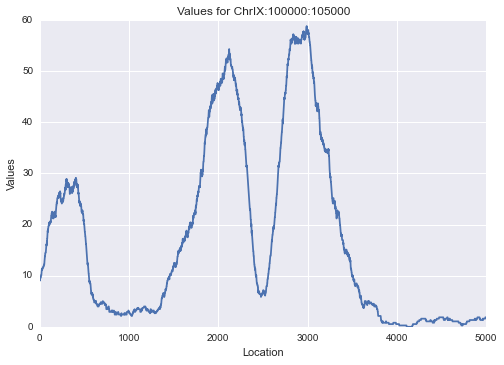

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
chr_IX_data=load_track('bar40.txt')
plt.plot(chr_IX_data[100000:105000]); #plotting the interval
plt.xlabel('Location');
plt.ylabel('Values');
plt.title('Values for ChrIX:100000:105000');

Of course the same strategy can be applied for data from all chromosome using a dictionary to store all chromosomes.

In [5]:
list_of_chromosomes = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV',
                          'XVI', 'MT'] # The names of all chromosomes
size_of_chromosomes = [230218, 813184, 316620, 1531933, 576874, 270161, 1090940, 562643, 439888, 745751, 666816,
                           1078177, 924431, 784333, 1091291, 948066, 85779] #the sizes of all chromosomes
chromosomes=[(chrom,size) for chrom,size in zip(list_of_chromosomes,size_of_chromosomes)]

And redefine the loading function 

In [6]:
def load_track(BED):
    """ This function creates a dictionary of arrays and populates it with data from the BED file"""
    data=dict()
    for item in chromosomes:
        data[item[0]]=np.zeros(item[1]) #create an empty array with the size of the chromosome
    with open(BED) as data_file:
        for line in data_file:
            row=line.split('\t')
            data[row[0]][int(row[1]):int(row[2])]=float(row[3]) #populate array
    return data

And now we have a dictionary containing the entire data track

In [7]:
track_data=load_track('bar40.txt')
for chromosome,size in track_data.items():
    print("Chromosome:{0} --> {1} bp".format(chromosome,len(size)))

Chromosome:VII --> 1090940 bp
Chromosome:V --> 576874 bp
Chromosome:XV --> 1091291 bp
Chromosome:I --> 230218 bp
Chromosome:VIII --> 562643 bp
Chromosome:XIII --> 924431 bp
Chromosome:XII --> 1078177 bp
Chromosome:II --> 813184 bp
Chromosome:XVI --> 948066 bp
Chromosome:XI --> 666816 bp
Chromosome:X --> 745751 bp
Chromosome:III --> 316620 bp
Chromosome:XIV --> 784333 bp
Chromosome:IV --> 1531933 bp
Chromosome:MT --> 85779 bp
Chromosome:IX --> 439888 bp
Chromosome:VI --> 270161 bp


And can plot the data using dictionary indexing

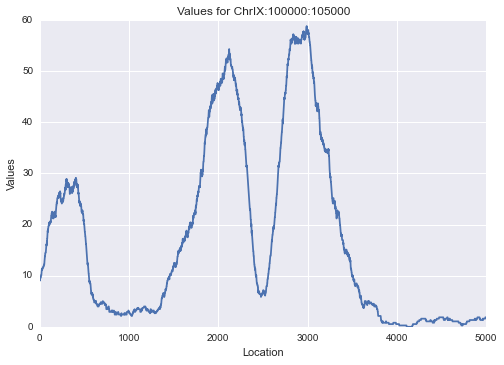

In [8]:
plt.plot(track_data['IX'][100000:105000]);
plt.xlabel('Location');
plt.ylabel('Values');
plt.title('Values for ChrIX:100000:105000');

While this approach works well for small genome sizes, there will probably problems with scalling up in larger genomes since the entire dictionary is kept in memory. And even for budding yeast the data would occupy several Mb, causing problems if you are working with more than a dataset.

In [9]:
#check the size of the dictionary
import sys
size=0
for values in track_data.values():
    size+=values.nbytes
print('Size of data in memory: {} bytes'.format(size))

Size of data in memory: 97256840 bytes


The footprint of a single dataset is more than 90 Mb. With human data there would probably be at least 100x bigger footprint.

This problem could be addressed in several ways: data could be loaded in numpy memory views and kept on disk or in case of data with low density, sparse matrices could be used. Another drawback of this approach is saving that data for later use, while you could pickle the data structure, this approach is not recommended since legacy problems could arise.

Luckily you can use HDF5 data model and it's implementation in python to address this problem

Creating a HDF5 is almost as simple as creating a dictionary and data access is also very similar

In [10]:
import h5py
#create an hdf5 file
hdf5_file=h5py.File("datasets.hdf5","w") #create a hdf5 file

def create_hdf5_track(dataset_name,hdf5_file_handler):
    temp=hdf5_file_handler.create_group(dataset_name) #create a first group with the name of our dataset
    for item in chromosomes:
        temp.create_dataset(item[0],(item[1],),dtype='f') #to the dataset group we add subgroups containing empty arrays

In [11]:
create_hdf5_track('bar40',hdf5_file) #populate the file
hdf5_file.visit(lambda x:print(x)) #check the organization of the file

bar40
bar40/I
bar40/II
bar40/III
bar40/IV
bar40/IX
bar40/MT
bar40/V
bar40/VI
bar40/VII
bar40/VIII
bar40/X
bar40/XI
bar40/XII
bar40/XIII
bar40/XIV
bar40/XV
bar40/XVI


Since hdf5 files are similar to dictionaries we can use functions similar to the ones defined before to load the data.

In [12]:
def load_track_in_hdf5(BED,hdf5):
    data=dict()
    for item in chromosomes:
        data[item[0]]=np.zeros(item[1]) #create an empty array with the size of the chromosome
    with open(BED) as data_file:
        for line in data_file:
            row=line.split('\t')
            data[row[0]][int(row[1]):int(row[2])]=float(row[3]) #populate array
    for key,value in data.items():
            hdf5['bar40'][key][...] = value #populate hdf5 file

We can now load our data in the hdf5 file

In [13]:
load_track_in_hdf5('bar40.txt',hdf5_file)

And confirm that it looks the same as before, only now is kept in the disk and not in memory.

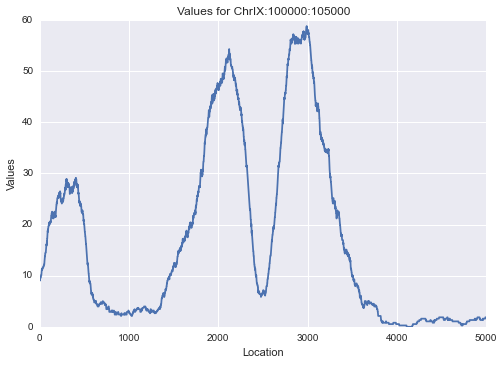

In [14]:
plt.plot(hdf5_file['bar40']['IX'][100000:105000]);
plt.xlabel('Location');
plt.ylabel('Values');
plt.title('Values for ChrIX:100000:105000');

Of course storing data in disk comes with an overhead on data access and accessing hd5f data is about 1000x slower however for large datasets it is probably a good tradeoff.

In [15]:
print("hdf5 access:",end=' ')
%timeit hdf5_file['bar40']['IX'][100000:150000] 
print("numpy array access:",end=' ')
%timeit track_data['IX'][100000:150000]

hdf5 access: 1000 loops, best of 3: 323 µs per loop
numpy array access: The slowest run took 17.69 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 371 ns per loop


One final modification is related to file size. HDF5 files are still quite large:

In [16]:
print(os.stat("datasets.hdf5").st_size)

48636036


However data can be compressed simply by setting parameters when creating the datasets:

In [17]:
hdf5_file_compressed=h5py.File("datasets_compressed.hdf5","w")

def create_hdf5_track_compressed(dataset_name,hdf5_file_handler):
    temp=hdf5_file_handler.create_group(dataset_name) #create a first group with the name of our dataset
    for item in chromosomes:
        temp.create_dataset(item[0],(item[1],),dtype='f',compression='gzip', compression_opts=9) 

create_hdf5_track_compressed('bar40',hdf5_file_compressed)

load_track_in_hdf5('bar40.txt',hdf5_file_compressed)


In [18]:
print("Compression rate: {}".format(os.stat("datasets_compressed.hdf5").st_size/os.stat("datasets.hdf5").st_size))

Compression rate: 0.1281802653489277


That's almost a 90% compression rate! And with only a small overhead on indexing:

In [19]:
print("hdf5 access:",end=' ')
%timeit hdf5_file['bar40']['IX'][100000:150000] 
print("compressed hdf5 access:",end=' ')
%timeit hdf5_file_compressed['bar40']['IX'][100000:150000]

hdf5 access: 1000 loops, best of 3: 322 µs per loop
compressed hdf5 access: 1000 loops, best of 3: 1.17 ms per loop
